In [272]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

os.chdir("/home/sdf/Projects/misc/izhevskoe_scans")

In [273]:
# Convert TIF to JPG
resize_coef = 10
!for file in data/tif/*.tif; do convert -resize 10% "$file" "data/jpg/$(basename "${file%.tif}.jpg")"; done

In [275]:
# Load the image
tif_dir = "data/tif"
jpg_dir = "data/jpg"

Симакин 10 001 — копия.tif


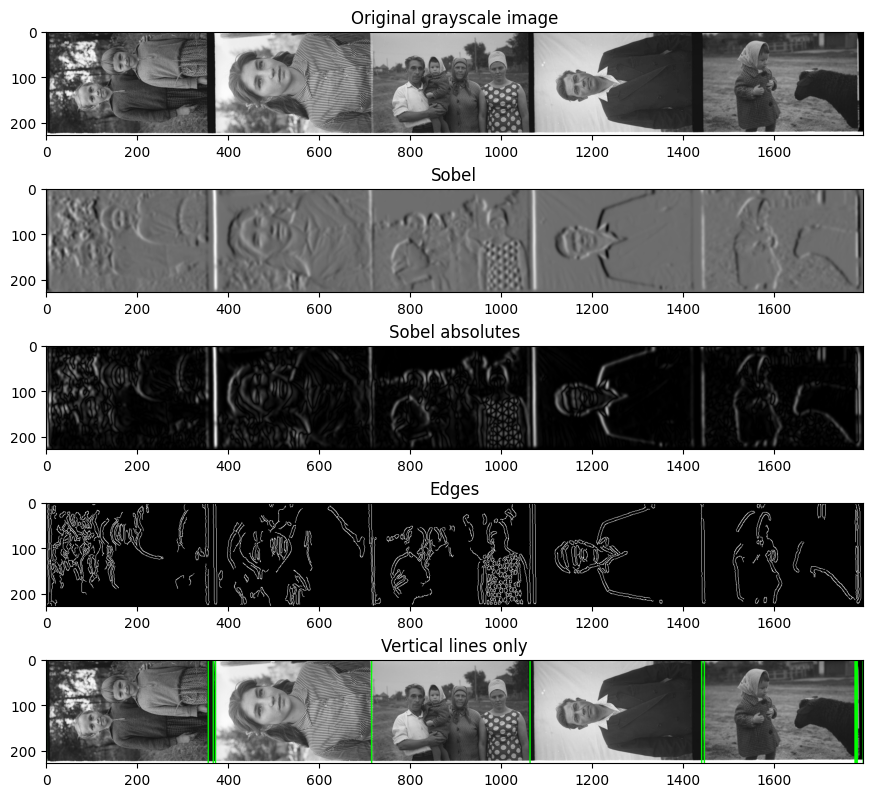


Симакин 1965 004 006 — копия.tif


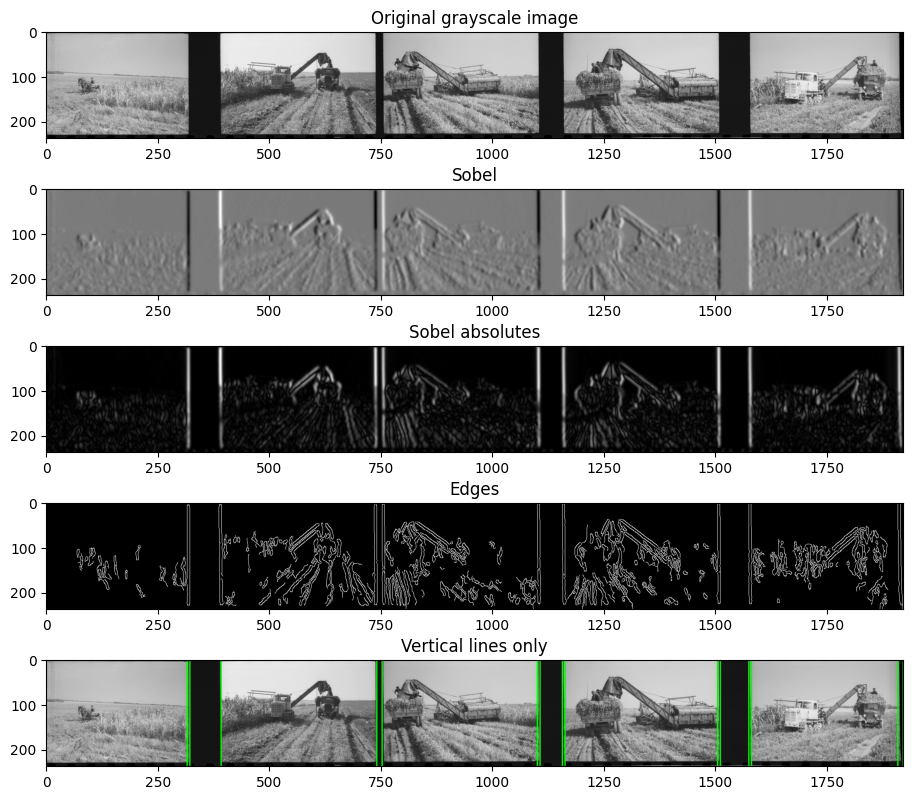


Симакин 1965 009 001 — копия.tif


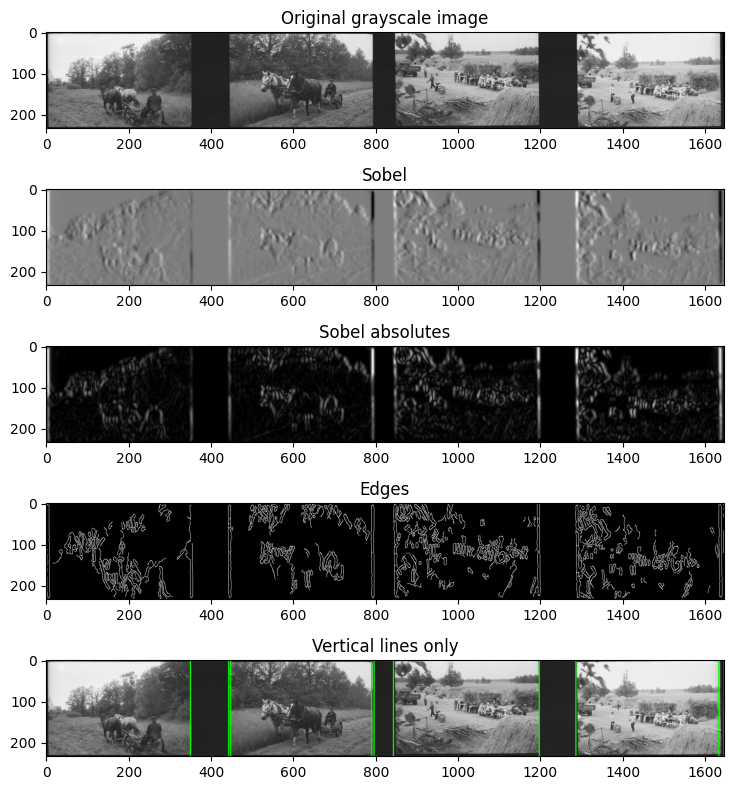

In [292]:
for file_tif, file_jpg in zip(sorted(os.listdir(tif_dir)), sorted(os.listdir(jpg_dir))):
    
    image_tif = cv2.imread(os.path.join(tif_dir, file_tif))
    image_jpg = cv2.imread(os.path.join(jpg_dir, file_jpg))
    image_to_draw_on = image_jpg

    # Convert to grayscale and apply Canny edge detection
    gray = cv2.cvtColor(image_jpg, cv2.COLOR_BGR2GRAY)

    # Apply Sobel operator to detect vertical edges
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=31)

    # Take the absolute value of the Sobel output
    abs_sobel64f = np.absolute(sobel)

    # Normalize the Sobel output to the range 0-255
    sobel_normalized = cv2.normalize(abs_sobel64f, None, 0, 255, cv2.NORM_MINMAX)

    # Convert normalized output to 8-bit image
    sobel_8u = np.uint8(sobel_normalized)

    # Apply Canny edge detection on the Sobel output
    edges = cv2.Canny(sobel_8u, 10, 150)

    # Find lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=40, maxLineGap=50)

    # Keep only vertical lines
    image_width = image_jpg.shape[1]
    vertical_lines_x = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(x1 - x2) < 10 and x1 > 10 and x1 < image_width - 10:
                vertical_lines_x.append(x1)

    vertical_lines_x.extend([0, image_width])
    vertical_lines_x = sorted(set(vertical_lines_x))
    
    # Draw the lines on the image
    for x in vertical_lines_x:
        cv2.line(image_to_draw_on, (x, 0), (x, image_to_draw_on.shape[0]), (0, 255, 0), 2)  # Draw vertical lines
        
    print(file_tif)

    # Show the results using Matplotlib
    plt.figure(figsize=(10, 8))

    plt.subplot(5, 1, 1)  # 5 rows, 1 column, 1st subplot
    plt.imshow(gray, cmap='gray')
    plt.title('Original grayscale image')

    plt.subplot(5, 1, 2)  
    plt.imshow(sobel, cmap='gray')
    plt.title('Sobel')

    plt.subplot(5, 1, 3)  
    plt.imshow(sobel_8u, cmap='gray')
    plt.title('Sobel absolutes')

    plt.subplot(5, 1, 4)  
    plt.imshow(edges, cmap='gray')
    plt.title('Edges')

    plt.subplot(5, 1, 5)  
    plt.imshow(image_to_draw_on, cmap='gray')
    plt.title('Vertical lines only')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()
    
    print("=" * 100)
    print()
    
    # Save
    os.makedirs("split/tif", exist_ok = True)
    
    vertical_lines_x_tif = [x * resize_coef for x in vertical_lines_x]
    
    frames = []
    for i in range(len(vertical_lines_x_tif) - 1):
        frame = image_tif[:, vertical_lines_x_tif[i]:vertical_lines_x_tif[i + 1]]
        if frame.shape[1] > 1000:
            frames.append(frame)
        
    for i in range(len(frames)):
        cv2.imwrite(f'split/tif/{file_tif.split("копия")[0].strip()} {i + 1}.tif', frames[i])
        

In [293]:
# Make smaller JPGs
os.makedirs("split/jpg", exist_ok = True)
!for file in split/tif/*.tif; do convert -resize 50% "$file" "split/jpg/$(basename "${file%.tif}.jpg")"; done
